Running enhanced optimization with uncertainty...

Performance Summary with Uncertainty Quantification:
 Phase    Date  HMA_NetReturn  MVO_NetReturn  EW_NetReturn  Forecast_Uncertainty
     1 2022-02      -0.003062      -0.044809     -0.025325              0.212836
     2 2022-03       0.008363       0.008394      0.030454              0.211280
     3 2022-04       0.017901       0.017443      0.003808              0.184512
     4 2022-05      -0.018950      -0.017967     -0.038829              0.180578
     5 2022-06      -0.043902      -0.005139     -0.057726              0.178673
     6 2022-07       0.080074       0.107109      0.114501              0.177560
     7 2022-08       0.098423       0.069941      0.042874              0.182480
     8 2022-09      -0.008125      -0.023829     -0.029544              0.181202
     9 2022-10       0.021486       0.036032      0.037275              0.178003
    10 2022-11       0.000073      -0.089030      0.029230              0.177955
    1

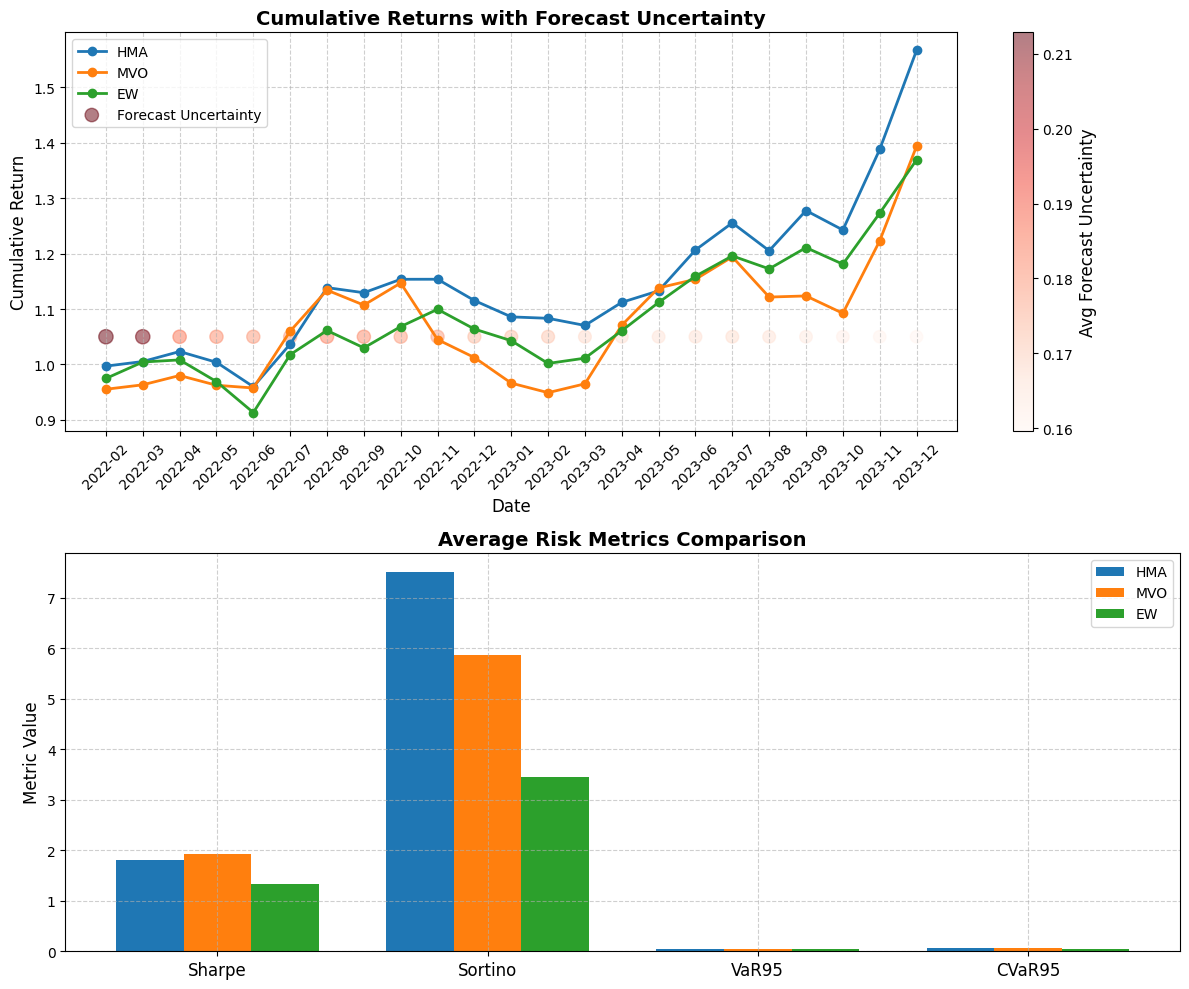

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
import warnings
warnings.filterwarnings("ignore")

# ----------------- Configuration -----------------
TICKERS = [
    'RELIANCE.NS', 'INFY.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'TCS.NS',
    'LT.NS', 'SBIN.NS', 'BHARTIARTL.NS', 'ITC.NS', 'KOTAKBANK.NS',
    'ASIANPAINT.NS', 'HINDUNILVR.NS', 'MARUTI.NS', 'SUNPHARMA.NS', 'AXISBANK.NS',
    'WIPRO.NS', 'ULTRACEMCO.NS', 'TECHM.NS', 'NTPC.NS', 'POWERGRID.NS',
    'TITAN.NS', 'BAJFINANCE.NS', 'NESTLEIND.NS', 'COALINDIA.NS', 'HCLTECH.NS',
    'GRASIM.NS', 'ADANIENT.NS', 'SBILIFE.NS', 'DIVISLAB.NS', 'DRREDDY.NS',
    'CIPLA.NS', 'BRITANNIA.NS', 'EICHERMOT.NS', 'HEROMOTOCO.NS', 'BAJAJ-AUTO.NS',
    'HINDALCO.NS', 'JSWSTEEL.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'BPCL.NS',
    'IOC.NS', 'INDUSINDBK.NS', 'APOLLOHOSP.NS', 'BAJAJFINSV.NS', 'HDFCLIFE.NS',
    'ADANIPORTS.NS', 'SHREECEM.NS', 'M&M.NS', 'SBICARD.NS', 'ICICIPRULI.NS'
]
START_DATE = '2020-01-01'
END_DATE = '2024-01-01'

ESTIMATION_WINDOW = 24   # months
TEST_WINDOW = 1          # months
CARDINALITY = 6          # max assets in portfolio
MAX_WEIGHT = 0.2
TRANSACTION_COST = 0.001
BLEND_RATIO = 0.5        # HMA/ETS blend
RISK_FREE_RATE = 0.03
CONFIDENCE_LEVEL = 0.9   # for uncertainty bounds

# ----------------- Data Loading -----------------
def download_monthly_prices(tickers, start, end):
    """Download and clean price data from Yahoo Finance"""
    raw = yf.download(tickers, start=start, end=end, progress=False)
    if isinstance(raw.columns, pd.MultiIndex):
        df = raw['Adj Close'] if 'Adj Close' in raw.columns.levels[0] else raw['Close']
    else:
        df = raw['Adj Close'] if 'Adj Close' in raw.columns else raw['Close']
    monthly = df.resample('ME').last()
    monthly.columns = [c.upper() for c in monthly.columns]
    return monthly.dropna(how='all', axis=1)

def monthly_returns(prices):
    """Calculate monthly returns with data validation"""
    returns = prices.pct_change().dropna(how='all')
    if returns.isnull().any().any():
        returns = returns.fillna(0)  # Fill any remaining NaNs with 0
    return returns

# ----------------- Forecasting with Uncertainty -----------------
def compute_forecast_with_uncertainty(series):
    """Returns (forecast, lower_bound, upper_bound)"""
    try:
        series = series.dropna()
        if len(series) < 6:
            val = series.iloc[-1] if len(series) > 0 else 0.0
            return (val, val, val)

        model = ExponentialSmoothing(series, trend='add', seasonal=None)
        fit = model.fit()
        forecast = fit.forecast(1)[0]

        # Simplified uncertainty estimation
        residuals = series - fit.fittedvalues
        std_error = np.std(residuals)
        z_score = 1.645  # For 90% CI
        lower = forecast - z_score * std_error
        upper = forecast + z_score * std_error

        return (forecast, lower, upper)
    except Exception:
        val = series.iloc[-1] if len(series) > 0 else 0.0
        return (val, val, val)

def blended_forecast_with_uncertainty(returns, est_period_idx):
    """Enhanced forecast with uncertainty bounds"""
    # Moving average component
    ma6 = returns.rolling(6, min_periods=3).mean()
    ma12 = returns.rolling(12, min_periods=6).mean()
    ma_forecast = 0.5 * ma6 + 0.5 * ma12

    # ETS component with parallel processing
    with ProcessPoolExecutor() as executor:
        ets_results = list(executor.map(
            compute_forecast_with_uncertainty,
            [returns[col].loc[est_period_idx] for col in returns.columns]
        ))

    # Combine forecasts
    forecasts = []
    for col, (ets_f, ets_lower, ets_upper) in zip(returns.columns, ets_results):
        ma_val = ma_forecast[col].loc[est_period_idx[-1]]
        blended = BLEND_RATIO * ma_val + (1-BLEND_RATIO) * ets_f

        # Conservative uncertainty bounds
        ma_std = returns[col].rolling(6).std().iloc[-1]
        blended_std = np.sqrt(
            (BLEND_RATIO*ma_std)**2 +
            ((1-BLEND_RATIO)*(ets_upper-ets_lower)/3.29)**2  # Convert 90% CI to std
        )

        forecasts.append((
            blended,
            blended - 1.645*blended_std,  # 90% lower bound
            blended + 1.645*blended_std   # 90% upper bound
        ))

    return pd.DataFrame(
        forecasts,
        index=returns.columns,
        columns=['forecast', 'lower_bound', 'upper_bound']
    )

# ----------------- Optimization -----------------
def optimize_mvo(mu, Sigma, max_weight=MAX_WEIGHT):
    """Standard MVO optimization"""
    n = len(mu)
    mu = np.array(mu, dtype=float)
    Sigma = np.array(Sigma, dtype=float)
    Sigma += np.eye(n) * 1e-6  # Regularization

    def objective(w):
        return float(w @ Sigma @ w) - 0.5 * mu @ w

    bounds = [(0.0, max_weight)] * n
    cons = ({'type':'eq','fun': lambda w: np.sum(w) - 1.0})
    x0 = np.ones(n)/n

    res = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=cons)

    w = np.maximum(res.x, 0)
    w = w / (w.sum() + 1e-10)
    w[w < 0.01] = 0
    return w / w.sum()

def robust_optimize(mu, Sigma, lower_bounds, upper_bounds):
    """MVO that accounts for forecast uncertainty"""
    # Conservative estimate: optimize for worst-case within bounds
    adjusted_mu = 0.7*mu + 0.3*lower_bounds  # 70-30 blend of central and lower estimates

    n = len(mu)
    def objective(w):
        return float(w @ Sigma @ w) - 0.5 * adjusted_mu @ w

    bounds = [(0.0, MAX_WEIGHT)] * n
    cons = ({'type':'eq','fun': lambda w: np.sum(w) - 1.0})
    x0 = np.ones(n)/n

    res = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=cons)

    w = np.maximum(res.x, 0)
    w = w / (w.sum() + 1e-10)
    w[w < 0.01] = 0
    return w / w.sum()

# ----------------- Asset Selection -----------------
def select_by_moving_average(prices_train, top_k=CARDINALITY):
    """Select assets based on momentum and volatility"""
    returns = prices_train.pct_change().dropna()
    momentum = (prices_train.ffill().rolling(3).mean() /
               prices_train.ffill().rolling(12).mean() - 1).iloc[-1]
    vol = returns.rolling(6).std().iloc[-1]

    df = pd.DataFrame({'momentum': momentum, 'vol': vol}).dropna()
    df = df.sort_values('momentum', ascending=False)
    return list(df.index[:top_k])

# ----------------- Performance Metrics -----------------
def annualized_sharpe(returns):
    """Improved Sharpe ratio calculation"""
    if len(returns) < 2:
        return 0.0
    excess_returns = returns - (RISK_FREE_RATE / 12)
    return np.sqrt(12) * excess_returns.mean() / (excess_returns.std() + 1e-10)

def annualized_sortino(returns):
    """Improved Sortino ratio calculation"""
    if len(returns) < 2:
        return 0.0
    downside = returns[returns < 0]
    if len(downside) == 0:
        return np.inf
    excess_returns = returns - (RISK_FREE_RATE / 12)
    return np.sqrt(12) * excess_returns.mean() / (downside.std() + 1e-10)

def var_cvar(returns, alpha=0.95):
    """Clearer risk metric calculation"""
    if len(returns) == 0:
        return 0.0, 0.0
    var = np.percentile(returns, 100*(1-alpha))
    cvar = returns[returns <= var].mean()
    return abs(var), abs(cvar)  # Return positive values for losses

def herfindahl(weights):
    """Diversity metric calculation"""
    w = np.array(list(weights.values()))
    return float(np.sum(w**2))

def turnover(prev_weights, new_weights):
    """Calculate portfolio turnover"""
    if prev_weights is None:
        return 0.0
    all_assets = set(prev_weights.keys()) | set(new_weights.keys())
    return sum(abs(new_weights.get(a, 0) - prev_weights.get(a, 0)) for a in all_assets)

def calculate_metrics(test_returns, weights_dict, prev_weights_dict, train_returns):
    """Calculate all performance metrics for each strategy"""
    metrics = {}

    for strategy, weights in weights_dict.items():
        # Get common assets between weights and test returns
        common_assets = [a for a in weights.keys() if a in test_returns.columns]
        if not common_assets:
            ret = 0.0
            strat_train_returns = pd.Series(0, index=train_returns.index)
        else:
            # Calculate test period return
            w_series = pd.Series(weights)[common_assets]
            ret = test_returns[common_assets].dot(w_series).iloc[0]

            # Calculate training period returns for risk metrics
            strat_train_returns = train_returns[common_assets].dot(w_series)

        # Transaction costs
        prev_weights = prev_weights_dict.get('hma' if strategy == 'HMA' else 'mvo', {})
        to = turnover(prev_weights, weights)
        net_ret = ret - TRANSACTION_COST * to

        # Risk metrics
        sharpe = annualized_sharpe(strat_train_returns)
        sortino = annualized_sortino(strat_train_returns)
        var, cvar = var_cvar(strat_train_returns)
        hhi = herfindahl(weights)

        metrics.update({
            f'{strategy}_Return': ret,
            f'{strategy}_NetReturn': net_ret,
            f'{strategy}_Sharpe': sharpe,
            f'{strategy}_Sortino': sortino,
            f'{strategy}_VaR95': var,
            f'{strategy}_CVaR95': cvar,
            f'{strategy}_HHI': hhi,
            f'{strategy}_Turnover': to
        })

    return metrics

# ----------------- Backtest -----------------
def run_backtest_with_uncertainty(prices):
    """Main backtest function with uncertainty quantification"""
    returns = monthly_returns(prices)
    dates = returns.index
    results = []
    prev_weights = {'hma': None, 'mvo': None}

    for p in range(len(dates) - ESTIMATION_WINDOW):
        est_period = dates[p:p+ESTIMATION_WINDOW]
        test_period = dates[p+ESTIMATION_WINDOW:p+ESTIMATION_WINDOW+TEST_WINDOW]

        if len(test_period) == 0:
            break

        # 1. Asset selection
        selected = select_by_moving_average(prices.loc[est_period])

        # 2. Enhanced forecasting with uncertainty
        forecast_df = blended_forecast_with_uncertainty(returns, est_period)
        mu_full = forecast_df['forecast']
        mu_lower = forecast_df['lower_bound']
        mu_upper = forecast_df['upper_bound']

        # 3. Portfolio optimization
        returns_train = returns.loc[est_period]

        # HMA Portfolio (with uncertainty)
        mu_sel = mu_full[selected].values
        mu_lower_sel = mu_lower[selected].values
        mu_upper_sel = mu_upper[selected].values
        cov_sel = returns_train[selected].cov().values
        w_hma = robust_optimize(mu_sel, cov_sel, mu_lower_sel, mu_upper_sel)
        weights_hma = dict(zip(selected, w_hma))

        # MVO Benchmark (traditional)
        cov_full = returns_train.cov().values
        w_mvo = optimize_mvo(mu_full.values, cov_full, max_weight=1.0)
        weights_mvo = dict(zip(returns.columns, w_mvo))

        # Equal Weight Benchmark
        weights_ew = {a: 1.0/len(returns.columns) for a in returns.columns}

        # Calculate metrics
        test_returns = returns.loc[test_period]
        metrics = calculate_metrics(
            test_returns,
            {'HMA': weights_hma, 'MVO': weights_mvo, 'EW': weights_ew},
            prev_weights,
            returns_train
        )

        # Store results with uncertainty info
        results.append({
            'Phase': p+1,
            'Date': test_period[0].strftime('%Y-%m'),
            'Forecast_Uncertainty': (mu_upper - mu_lower).mean(),  # Avg uncertainty
            **metrics
        })

        prev_weights = {'hma': weights_hma, 'mvo': weights_mvo}

    return pd.DataFrame(results)

# ----------------- Visualization -----------------
def plot_results_with_uncertainty(results):
    """Plot cumulative returns with forecast uncertainty + bar chart of risk metrics"""
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))

    # ----------- Plot 1: Cumulative Returns with Uncertainty -----------
    for strategy in ['HMA', 'MVO', 'EW']:
        cum_ret = (1 + results[f'{strategy}_NetReturn']).cumprod()
        axs[0].plot(results['Date'], cum_ret, label=f'{strategy}', marker='o', linewidth=2)

    uncertainty = results['Forecast_Uncertainty']
    sc = axs[0].scatter(results['Date'], [1.05] * len(results),
                        c=uncertainty, cmap='Reds', alpha=0.5,
                        s=uncertainty * 500, label='Forecast Uncertainty')
    cbar = plt.colorbar(sc, ax=axs[0])
    cbar.set_label('Avg Forecast Uncertainty', fontsize=12)

    axs[0].set_title('Cumulative Returns with Forecast Uncertainty', fontsize=14, fontweight='bold')
    axs[0].set_xlabel('Date', fontsize=12)
    axs[0].set_ylabel('Cumulative Return', fontsize=12)
    axs[0].legend()
    axs[0].grid(True, linestyle='--', alpha=0.6)
    axs[0].tick_params(axis='x', rotation=45)

    # ----------- Plot 2: Bar Chart of Average Risk Metrics -----------
    avg_metrics = results[[
        'HMA_Sharpe', 'MVO_Sharpe', 'EW_Sharpe',
        'HMA_Sortino', 'MVO_Sortino', 'EW_Sortino',
        'HMA_VaR95', 'MVO_VaR95', 'EW_VaR95',
        'HMA_CVaR95', 'MVO_CVaR95', 'EW_CVaR95'
    ]].mean()

    # Organize for bar plot
    metrics_names = ['Sharpe', 'Sortino', 'VaR95', 'CVaR95']
    strategies = ['HMA', 'MVO', 'EW']
    bar_data = {metric: [avg_metrics[f"{s}_{metric}"] for s in strategies] for metric in metrics_names}

    x = np.arange(len(metrics_names))
    width = 0.25
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

    for i, strategy in enumerate(strategies):
        axs[1].bar(x + i*width - width, [bar_data[m][i] for m in metrics_names],
                   width=width, label=strategy, color=colors[i])

    axs[1].set_xticks(x)
    axs[1].set_xticklabels(metrics_names, fontsize=12)
    axs[1].set_ylabel('Metric Value', fontsize=12)
    axs[1].set_title('Average Risk Metrics Comparison', fontsize=14, fontweight='bold')
    axs[1].legend()
    axs[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


# ----------------- Main Execution -----------------
if __name__ == "__main__":
    print("Running enhanced optimization with uncertainty...")
    prices = download_monthly_prices(TICKERS, START_DATE, END_DATE)
    results = run_backtest_with_uncertainty(prices)

    # Print performance summary
    print("\nPerformance Summary with Uncertainty Quantification:")
    print(results[['Phase', 'Date', 'HMA_NetReturn', 'MVO_NetReturn', 'EW_NetReturn', 'Forecast_Uncertainty']].to_string(index=False))

    # Print average metrics
    avg_metrics = results[[
        'HMA_Sharpe', 'MVO_Sharpe', 'EW_Sharpe',
        'HMA_Sortino', 'MVO_Sortino', 'EW_Sortino',
        'HMA_VaR95', 'MVO_VaR95', 'EW_VaR95',
        'HMA_HHI', 'MVO_HHI', 'EW_HHI'
    ]].mean()

    print("\nAverage Metrics:")
    print(avg_metrics.to_string())

    # Plot results
    plot_results_with_uncertainty(results)

Config → Download Monthly Prices → Calculate Returns
       → Select Top Assets → Forecast with Uncertainty
       → Optimize Portfolios (HMA & MVO)
       → Calculate Metrics → Store Results
       → Move Forward 1 Month → Repeat
       → Summarize & Plot
